In [1]:
from pprint import pprint
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import figure
path_to_statistic_data_folder = r'/sise/home/shouei/reddit_code_shai/statistics_by_status_and_time_comments/'
# 

In [2]:
# Insert the directory path in here
path = path_to_statistic_data_folder
 
# Extracting all the contents in the directory corresponding to path
l_files = os.listdir(path)
file_set = set()
all_files = {}
for file in l_files:
    subreddit_name = file.split('_')[0][0:].replace('\\', '')
    file_set.add(subreddit_name)
    if subreddit_name not in all_files.keys():
        all_files[subreddit_name] = []
    all_files[subreddit_name].append(file)    
print(file_set)

{'WSB', 'MR', 'CRYPT', 'CONS', 'POL'}


In [3]:
def get_params():
    chosed_subreddit = 'WSB'
    n_days = 10
    start_date = '2020-01-01'
    end_date = '2020-12-31'
    range_flag = False
    return chosed_subreddit, n_days, start_date, end_date, range_flag


def draw_data(period, data, chosed_subreddit):
    
    Sum_posts = data['Sum']
    newdf = pd.concat([Sum_posts]*6, ignore_index=True)
    Sum_obj = [x for x in newdf.values.tolist()]
    data = data.drop(['Sum'], axis=1) 
    
    fig1 = plt.figure(figsize=(20, 15))
    ax = plt.gca()
    data.index = data.index.strftime('%y-%m-%d')
    assert plt.gcf() is fig1 # succeeds
    data.plot(ax=ax, kind='bar', stacked=True,
            title=chosed_subreddit + ": " + period +' statistics') #Stacked Bar Graph by dataframe
    for p, quan in zip(ax.patches, Sum_obj):
        width, height = p.get_width(), p.get_height()
        percentage = '{:.0f} %'.format((height/quan)*100)
        if percentage =='0 %':
            continue
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                percentage, 
                horizontalalignment='center', 
                verticalalignment='center')
    assert plt.gcf() is fig1 # Succeeds now, too
    
def sum_data(df, n_days):
    # applying groupby
    return df.groupby(pd.Grouper(key='Date', axis=0, 
                          freq='{}D'.format(n_days), sort=True)).sum()

def parse_date(Date):
    year = int(Date[0:4])
    month = int(Date[5:7])
    day = int(Date[8::])
    return year, month, day   



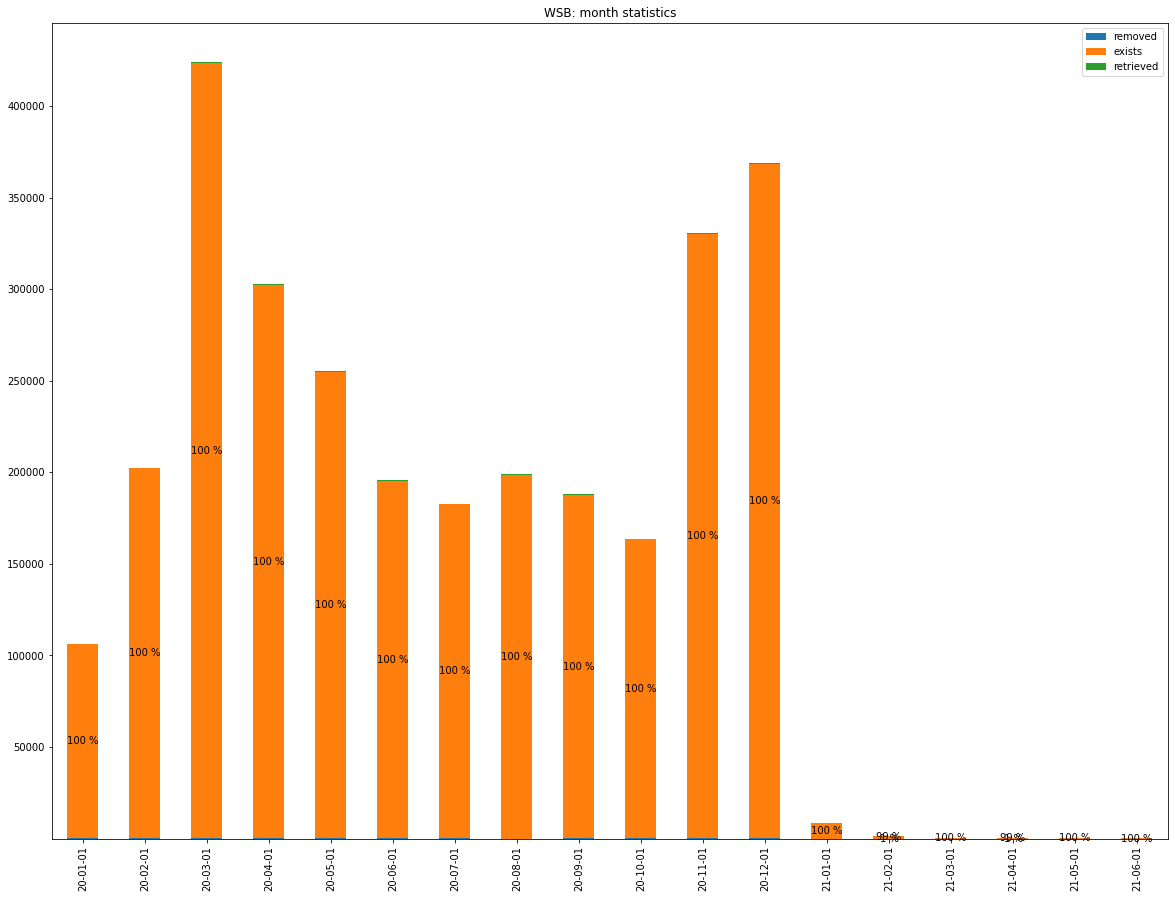

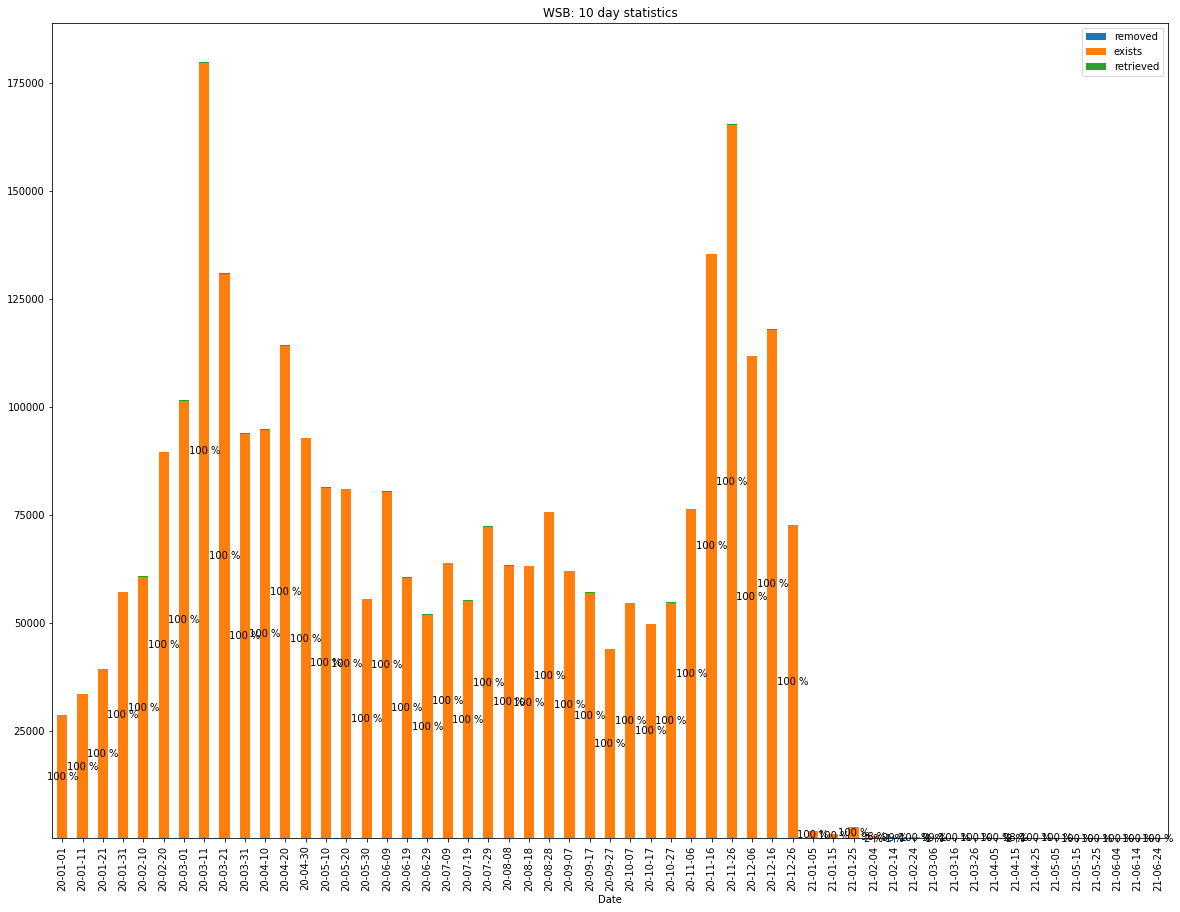

In [4]:
from db_utils.FileReader import FileReader
fr = FileReader()
chosed_subreddit, n_days, start_date, end_date, range_flag = get_params()
for file_name in all_files[chosed_subreddit]:
    period = file_name.split("_")[-1][:-5]
    subreddiit_path_to_analysis = path_to_statistic_data_folder + file_name
    data = fr.read_from_json_to_dict(subreddiit_path_to_analysis)
    data = pd.DataFrame(data).T
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    if period != 'month':
        data['Date'] = data.index
        data['Date'] = data['Date'].apply(lambda x: pd.Timestamp(x))
        if range_flag == True:
            start_date_year, start_date_month, start_date_day = parse_date(start_date) 
            end_date_year, end_date_month, end_date_day = parse_date(end_date) 
            data = data[(data['Date'] > pd.Timestamp(year=start_date_year, month=start_date_month, day=start_date_day, hour=0)) &
                        (data['Date'] <= pd.Timestamp(year=end_date_year, month=end_date_month, day=end_date_day, hour=1))]
        
        data = sum_data(data, n_days)
        period = "{} {}".format(n_days, period)
    data['Sum'] = data.sum(axis=1)
    draw_data(period, data, chosed_subreddit)
